In [105]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [106]:
# TODO: change this to yours ...
DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)




with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [107]:

def aggregate_admission_data(df, ehr_dict, aggregation, has_labels=True):
    """Aggregate features per admission with optional labels"""
    admission_ids = df['id'].unique()
    X = []
    y = [] if has_labels else None
    
    for adm_id in admission_ids:
        adm_rows = df[df['id'] == adm_id]
        adm_features = ehr_dict[adm_id]
        
        if aggregation == 'last':
            features = adm_features[-1]
        elif aggregation == 'mean':
            features = np.mean(adm_features, axis=0)
        elif aggregation == 'max':
            features = np.max(adm_features, axis=0)
        else:
            raise ValueError("Invalid aggregation method")
        
        X.append(features)
        
        if has_labels:
            y.append(adm_rows['readmitted_within_30days'].iloc[0])
    
    return np.array(X), (np.array(y) if has_labels else None)

# Process datasets
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'mean') # change last/max/mean
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'mean') 
X_test = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'mean', has_labels=False)[0]

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)


In [108]:

from scipy.stats import pointbiserialr, chi2_contingency
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]  

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []

for i in range(X_train.shape[1]):
    feature_name = feature_names[i]
    
    # Skip constant features
    if np.std(X_train[:, i]) == 0:
        correlations.append(0)
        p_values.append(1)
        continue
        
    # Use chi-squared for ICD features, point-biserial for others
    if feature_name in ehr_data["icd_cols"]:
        # Chi-squared test for binary ICD features
        contingency_table = pd.crosstab(X_train[:, i], y_train)
        try:
            chi2, pval, _, _ = chi2_contingency(contingency_table)
            correlations.append(chi2)  # Using chi2 statistic as effect size
            p_values.append(pval)
        except:
            correlations.append(0)
            p_values.append(1)
    else:
        # Point-biserial for continuous features
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)
        


# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',
    
    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',
    
    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.95     # Demographics rarely zero
    },
    'std_dev': 0.001,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.001,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]
        
        # Skip binary features for variance check
        check_variance = ftype not in ['icd']
        
        if ftype == 'icd':
            sig_threshold = 0.05  # Could use different threshold for chi-square
            effect_size = row['Correlation']  # Actually contains chi2 statistic
        else:
            sig_threshold = thresholds['correlation']['max_pvalue']
            effect_size = np.abs(row['Correlation'])
        
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (effect_size < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > sig_threshold):
            if feature not in clinically_relevant:
                features_to_remove.append(feature)
            


    
filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features) 
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)
X_test_filtered =remove_features(X_test, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features) 
                     if i not in remove_indices]



print(X_train_filtered.shape)






(8234, 133)


/var/folders/79/xhsm8rlj5fz4b46rjy_ls9t40000gn/T/ipykernel_67738/611880398.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [109]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

def compute_feature_associations(X, y, feature_names, ehr_data):
    correlations = []
    p_values = []
    
    for i in range(X.shape[1]):
        if np.std(X[:, i]) == 0:  
            correlations.append(0)
            p_values.append(1)
            continue
            
        if feature_names[i] in ehr_data["icd_cols"]:
            # Chi-squared for ICD features
            contingency = pd.crosstab(X[:, i], y)
            try:
                chi2, pval, _, _ = chi2_contingency(contingency)
                correlations.append(chi2)
                p_values.append(pval)
            except:
                correlations.append(0)
                p_values.append(1)
        else:
            # Point-biserial for continuous features
            corr, pval = pointbiserialr(X[:, i], y)
            correlations.append(corr)
            p_values.append(pval)
    
    return pd.DataFrame({
        'Feature': feature_names,
        'Association': correlations,
        'P-value': p_values
    })

# 2. Function to identify highly correlated features
def find_collinear_features(X, feature_names, threshold=0.8):
    """Identify feature pairs with correlation > threshold"""
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_pairs = [(feature_names[i], feature_names[j], corr_matrix.iloc[i,j]) 
                      for i,j in zip(*np.where(upper > threshold))]
    return pd.DataFrame(collinear_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

# 3. Feature selection based on clinical relevance and collinearity
def select_non_collinear_features(X, feature_names, ehr_data, 
                                clinically_relevant, corr_threshold=0.8):
    # Standardize data for proper correlation calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find all collinear pairs
    collinear_df = find_collinear_features(X_scaled, feature_names, corr_threshold)
    
    # Get feature importance scores
    importance = mutual_info_classif(X, y_train, random_state=42)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    features_to_keep = set(clinically_relevant)  # Always keep these
    
    # For non-clinical features, keep the more important one from collinear pairs
    for _, row in collinear_df.iterrows():
        f1, f2 = row['Feature1'], row['Feature2']
        
        # Skip if either is clinically relevant
        if f1 in clinically_relevant or f2 in clinically_relevant:
            continue
            
        # Keep feature with higher importance
        imp1 = importance_df.loc[importance_df['Feature'] == f1, 'Importance'].values[0]
        imp2 = importance_df.loc[importance_df['Feature'] == f2, 'Importance'].values[0]
        
        if imp1 > imp2:
            features_to_keep.add(f1)
        else:
            features_to_keep.add(f2)
    
    # Add any features not involved in collinearity
    all_features = set(feature_names)
    features_to_keep.update(all_features - set(collinear_df[['Feature1','Feature2']].values.flatten()))
    
    # Get indices of features to keep
    keep_indices = [i for i, f in enumerate(feature_names) if f in features_to_keep]
    remaining_features = [f for f in feature_names if f in features_to_keep]
    
    return keep_indices, remaining_features



# 1. Compute associations with target
assoc_df = compute_feature_associations(X_train_filtered, y_train, remaining_features, ehr_data)

# 2. Find and handle collinearity
keep_indices, non_collinear_features = select_non_collinear_features(
    X_train_filtered,
    remaining_features,
    ehr_data,
    clinically_relevant,
    corr_threshold=0.7  # Adjust based on your needs
)

# 3. Apply final filtering
X_train_final = X_train_filtered[:, keep_indices]
X_val_final = X_val_filtered[:, keep_indices]
X_test_final = X_test_filtered[:, keep_indices]





In [110]:
print(X_train_final.shape)

(8234, 130)


Logistic Regression Training

In [116]:
# Get ALL features that met removal criteria (before clinical override)
all_meet_criteria = combined_df[
    (combined_df['Zero_Ratio'] > combined_df['Feature'].map(
        lambda x: thresholds['zero_ratio']['icd'] if x in ehr_data["icd_cols"] else 
        thresholds['zero_ratio']['lab'] if x in ehr_data["lab_cols"] else
        thresholds['zero_ratio']['med'] if x in ehr_data["med_cols"] else
        thresholds['zero_ratio']['demo']
    )) &
    ((combined_df['Std_Dev'] < thresholds['std_dev']) | 
     (combined_df['Feature'].isin(ehr_data["icd_cols"]))) &
    (combined_df['Abs_Correlation'] < thresholds['correlation']['min_abs_corr']) &
    (combined_df['P-value'] > thresholds['correlation']['max_pvalue'])
].sort_values(by='Zero_Ratio', ascending=False)

# Get clinically protected features that WOULD HAVE been removed
clinically_protected_removed = all_meet_criteria[
    all_meet_criteria['Feature'].isin(clinically_relevant)
]

# Print summary
print(f"\n{' Feature Filtering Summary ':=^80}")
print(f"{'Total features initially considered:':<40} {len(combined_df)}")
print(f"{'Features meeting ALL removal criteria:':<40} {len(all_meet_criteria)}")
print(f"{'  - Clinically protected (kept):':<40} {len(clinically_protected_removed)}")
print(f"{'  - Actually removed:':<40} {len(features_to_remove)}\n")

# Print top 10 that met criteria (including protected)
print("\nTop 10 Features Meeting ALL Removal Criteria (Before Clinical Override):")
print("="*100)
print(f"{'Feature':<30} {'Type':<10} {'Std Dev':<10} {'P-value':<10} {'Zero Ratio':<12} {'Correlation':<12} {'Action':<15}")
print("-"*100)
for _, row in all_meet_criteria.head(10).iterrows():
    feature_type = (
        'ICD' if row['Feature'] in ehr_data["icd_cols"] else
        'Lab' if row['Feature'] in ehr_data["lab_cols"] else
        'Meds' if row['Feature'] in ehr_data["med_cols"] else 'Demo'
    )
    action = 'KEPT (Clinical)' if row['Feature'] in clinically_relevant else 'REMOVED'
    print(f"{row['Feature']:<30} {feature_type:<10} {row['Std_Dev']:.6f}  {row['P-value']:.4f}    {row['Zero_Ratio']:.4f}      {row['Correlation']:.6f}  {action:<15}")

# Print final removed features
print("\n\nTop 10 Features Actually Removed (After Clinical Override):")
print("="*100)
print(f"{'Feature':<30} {'Type':<10} {'Std Dev':<10} {'P-value':<10} {'Zero Ratio':<12} {'Correlation':<12}")
print("-"*100)
for _, row in removal_df.head(10).iterrows():
    feature_type = (
        'ICD' if row['Feature'] in ehr_data["icd_cols"] else
        'Lab' if row['Feature'] in ehr_data["lab_cols"] else
        'Meds' if row['Feature'] in ehr_data["med_cols"] else 'Demo'
    )
    print(f"{row['Feature']:<30} {feature_type:<10} {row['Std_Dev']:.6f}  {row['P-value']:.4f}    {row['Zero_Ratio']:.4f}      {row['Correlation']:.6f}")


========================== Feature Filtering Summary ===========================
Total features initially considered:     171
Features meeting ALL removal criteria:   41
  - Clinically protected (kept):         3
  - Actually removed:                    38


Top 10 Features Meeting ALL Removal Criteria (Before Clinical Override):
Feature                        Type       Std Dev    P-value    Zero Ratio   Correlation  Action         
----------------------------------------------------------------------------------------------------
K65-K68                        ICD        0.015583  1.0000    0.9999      0.000000  REMOVED        
M80-M85                        ICD        0.011020  1.0000    0.9999      0.000000  REMOVED        
N20-N23                        ICD        0.011020  1.0000    0.9999      0.000000  REMOVED        
J20-J22                        ICD        0.011020  1.0000    0.9999      0.000000  REMOVED        
F70-F79                        ICD        0.031155  1.0000  

In [115]:
# Get clinically protected features that met removal criteria
clinically_protected_removed = combined_df[
    combined_df['Feature'].isin(clinically_relevant) & 
    (combined_df['Zero_Ratio'] > combined_df['Feature'].map(
        lambda x: thresholds['zero_ratio']['icd'] if x in ehr_data["icd_cols"] else
        thresholds['zero_ratio']['lab'] if x in ehr_data["lab_cols"] else
        thresholds['zero_ratio']['med'] if x in ehr_data["med_cols"] else
        thresholds['zero_ratio']['demo']
    )) &
    ((combined_df['Std_Dev'] < thresholds['std_dev']) | 
     (combined_df['Feature'].isin(ehr_data["icd_cols"]))) &
    (combined_df['Abs_Correlation'] < thresholds['correlation']['min_abs_corr']) &
    (combined_df['P-value'] > thresholds['correlation']['max_pvalue'])
].sort_values(by='Zero_Ratio', ascending=False)

# Print the top 3 clinically protected features that would have been removed
print("\nTop 3 Clinically Protected Features That Met Removal Criteria (But Were Kept):")
print("="*110)
print(f"{'Feature':<30} {'Type':<10} {'Std Dev':<10} {'P-value':<10} {'Zero Ratio':<12} {'Correlation':<12} {'Clinical Rationale':<30}")
print("-"*110)

# Define clinical rationales (you can expand this dictionary)
clinical_rationales = {
    'Troponin T Blood': "Cardiac injury marker (guideline-mandated)",
    'ANTICOAGULANTS': "Stroke prevention (high-risk patients)",
    'I10-I16': "Hypertension management (JNC-8 guidelines)",
    'Creatinine Blood': "Kidney function gold standard",
    'Hemoglobin Blood': "Anemia/bleeding risk indicator"
}

top_3_protected = clinically_protected_removed.head(3)
for _, row in top_3_protected.iterrows():
    feature_type = (
        'ICD' if row['Feature'] in ehr_data["icd_cols"] else
        'Lab' if row['Feature'] in ehr_data["lab_cols"] else
        'Meds' if row['Feature'] in ehr_data["med_cols"] else 'Demo'
    )
    rationale = clinical_rationales.get(row['Feature'], "Clinical consensus")
    
    print(f"{row['Feature']:<30} {feature_type:<10} {row['Std_Dev']:.6f}  {row['P-value']:.4f}    {row['Zero_Ratio']:.4f}      {row['Correlation']:.6f}  {rationale:<30}")

# Print how many were protected total
print(f"\nTotal clinically protected features kept despite meeting removal criteria: {len(clinically_protected_removed)}")


Top 3 Clinically Protected Features That Met Removal Criteria (But Were Kept):
Feature                        Type       Std Dev    P-value    Zero Ratio   Correlation  Clinical Rationale            
--------------------------------------------------------------------------------------------------------------
J40-J47                        ICD        0.031155  1.0000    0.9985      0.000000  Clinical consensus            
E70-E88                        ICD        0.000000  1.0000    0.9978      0.000000  Clinical consensus            
ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS Meds       0.000000  1.0000    0.9961      0.000000  Clinical consensus            

Total clinically protected features kept despite meeting removal criteria: 3


In [120]:
def analyze_collinearity(X, feature_names, clinically_relevant, corr_threshold=0.7):
    """
    Identifies and analyzes collinear feature pairs with clinical relevance consideration
    
    Args:
        X: Feature matrix (n_samples x n_features)
        feature_names: List of feature names
        clinically_relevant: List of protected features
        corr_threshold: Correlation threshold (default: 0.7)
    
    Returns:
        DataFrame with collinear pairs and processing recommendations
    """
    # Standardize data for correlation analysis
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate correlation matrix
    corr_matrix = pd.DataFrame(X_scaled, columns=feature_names).corr().abs()
    
    # Get upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find feature pairs above threshold
    collinear_pairs = []
    for i, j in zip(*np.where(upper > corr_threshold)):
        f1, f2 = feature_names[i], feature_names[j]
        r = upper.iloc[i,j]
        
        # Determine clinical protection status
        f1_protected = f1 in clinically_relevant
        f2_protected = f2 in clinically_relevant
        
        collinear_pairs.append({
            'Feature1': f1,
            'Feature2': f2,
            'Correlation': r,
            'Feature1_Protected': f1_protected,
            'Feature2_Protected': f2_protected,
            'Recommended_Action': 'Keep both' if (f1_protected and f2_protected) else 
                                f'Keep {f1}' if f1_protected else
                                f'Keep {f2}' if f2_protected else
                                'Compare MI'
        })
    
    # Create results DataFrame
    collinear_df = pd.DataFrame(collinear_pairs)
    
    # Add mutual information for non-protected pairs
    if not collinear_df.empty:
        mi_scores = mutual_info_classif(X, y_train, random_state=42)
        mi_df = pd.DataFrame({'Feature': feature_names, 'MI_Score': mi_scores})
        
        collinear_df = collinear_df.merge(
            mi_df, left_on='Feature1', right_on='Feature', how='left'
        ).merge(
            mi_df, left_on='Feature2', right_on='Feature', 
            suffixes=('_1', '_2'), how='left'
        ).drop(columns=['Feature_1', 'Feature_2'])
        
        # Update recommendation based on MI scores for non-protected pairs
        mask = collinear_df['Recommended_Action'] == 'Compare MI'
        collinear_df.loc[mask, 'Recommended_Action'] = collinear_df[mask].apply(
            lambda x: f'Keep {x["Feature1"]}' if x['MI_Score_1'] > x['MI_Score_2'] 
                     else f'Keep {x["Feature2"]}', axis=1
        )
    
    return collinear_df.sort_values('Correlation', ascending=False)

# Run analysis
collinear_results = analyze_collinearity(
    X_train_filtered, 
    remaining_features, 
    clinically_relevant,
    corr_threshold=0.7
)

# Generate report
print("\nCollinear Feature Analysis Report")
print("="*100)
print(f"Total collinear pairs found (r > 0.7): {len(collinear_results)}")
print(f"Clinically protected features involved: {len(collinear_results[collinear_results['Feature1_Protected'] | collinear_results['Feature2_Protected']])}")

# Print top 20 collinear pairs
pd.set_option('display.max_columns', None)
print("\nTop 20 Collinear Pairs:")
print(collinear_results.head(20).to_string(index=False))

# Save full results
collinear_results.to_csv('collinear_features_report.csv', index=False)


Collinear Feature Analysis Report
Total collinear pairs found (r > 0.7): 6
Clinically protected features involved: 4

Top 20 Collinear Pairs:
           Feature1          Feature2  Correlation  Feature1_Protected  Feature2_Protected       Recommended_Action  MI_Score_1  MI_Score_2
  Lymphocytes Blood Neutrophils Blood     0.931526               False               False   Keep Neutrophils Blood    0.004266    0.005554
   Hemoglobin Blood  Hematocrit Blood     0.921437                True                True                Keep both    0.000000    0.000405
          pO2 Blood        pCO2 Blood     0.892241                True                True                Keep both    0.061391    0.052008
          pO2 Blood          pH Blood     0.862689                True               False           Keep pO2 Blood    0.061391    0.048842
           pH Blood        pCO2 Blood     0.826876               False                True          Keep pCO2 Blood    0.048842    0.052008
Lymphocytes Ascit

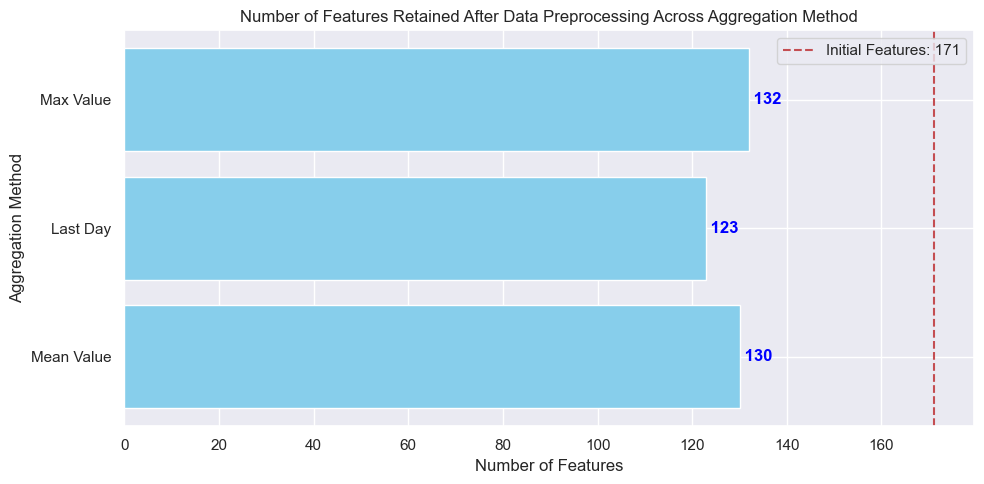

In [130]:
import matplotlib.pyplot as plt

# Data setup
aggregation_methods = ['Mean Value', 'Last Day', 'Max Value']
features_retained = [130, 123, 132]
initial_features = 171

# Create horizontal bar graph
plt.figure(figsize=(10, 5))
bars = plt.barh(aggregation_methods, features_retained, color='skyblue')

# Add initial feature count as a line for comparison
plt.axvline(x=initial_features, color='r', linestyle='--', label=f'Initial Features: {initial_features}')

# Adding data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f' {bar.get_width()}', 
             va='center', ha='left', color='blue', fontweight='bold')

# Title and labels
plt.title('Number of Features Retained After Data Preprocessing Across Aggregation Method')
plt.xlabel('Number of Features')
plt.ylabel('Aggregation Method')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()